# Groceries E-commerce EDA


In [1]:
# Imports and constants

import os
import boto3
from dotenv import load_dotenv
import pathlib
import pandas as pd
import fastparquet as fp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from typing import Optional, Tuple, List, Dict, Any
import calendar
from itertools import chain
from collections import Counter


# Load environment variables from .env file
load_dotenv()
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
S3_PATH = "s3://zrive-ds-data/groceries/sampled-datasets/"
LOCAL_DATA_PATH = 'groceries_data/'


## 1. Download or get data

First time we need to download the data from AWS s3://zrive-ds-data/groceries/sampled-datasets/ and save it. Next times, we only need to access local data. 

In [2]:
def download_grocery_data(aws_url: str, local_path: str) -> None:
    """
    Downloads all grocery data files (.parquet) from s3 dir and saves them to the specified local path.
    """
    
    # Create local directory if it doesn't exist
    pathlib.Path(local_path).mkdir(parents=True, exist_ok=True)

    # Initialize S3 client
    s3 = boto3.client(
        's3',
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY
    )

    # Extract bucket name and prefix from the S3 path
    bucket_name = aws_url.split('/')[2]
    prefix = '/'.join(aws_url.split('/')[3:])
    print(f"Bucket_name: {bucket_name}, Prefix: {prefix}")

    # List objects in the specified S3 bucket and prefix
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    if 'Contents' not in response:
        print("No contents found in the specified S3 path.")
        return
    for obj in response['Contents']:
        file_key = obj['Key']
        file_name = os.path.basename(file_key)
        local_file_path = os.path.join(local_path, file_name)

        # Download the file
        print(f"Downloading {file_key} to {local_file_path}")
        s3.download_file(bucket_name, file_key, local_file_path)



def data_file_exists(local_path: str, filename: str) -> bool:
    """
    Check if the specified file exists in the local directory.
    """
    file_path = os.path.join(local_path, filename)
    return os.path.isfile(file_path)


def get_grocery_file(file: str = 'orders.parquet') -> pd.DataFrame:
    """
    Main function to get grocery file. Downloads all the data if file doesn't exist locally.
    """
    # Check if the file exists locally
    if not data_file_exists(LOCAL_DATA_PATH, file):
        # If the file doesn't exist, download all grocery data
        download_grocery_data(S3_PATH, LOCAL_DATA_PATH)
    else:
        print(f"File {file} already exists locally. Skipping download.")
    # Read the parquet file into a DataFrame
    file_path = os.path.join(LOCAL_DATA_PATH, file)
    print(f"Reading {file_path} into DataFrame")
    orders_df = pd.read_parquet(file_path, engine='fastparquet')
    
    return orders_df

Get all parquet files and convert to DataFrames

In [3]:
orders_df = get_grocery_file('orders.parquet')
regulars_df = get_grocery_file('regulars.parquet')
abandoned_carts_df = get_grocery_file('abandoned_carts.parquet')
inventory_df = get_grocery_file('inventory.parquet')
users_df = get_grocery_file('users.parquet')

File orders.parquet already exists locally. Skipping download.
Reading groceries_data/orders.parquet into DataFrame
File regulars.parquet already exists locally. Skipping download.
Reading groceries_data/regulars.parquet into DataFrame
File abandoned_carts.parquet already exists locally. Skipping download.
Reading groceries_data/abandoned_carts.parquet into DataFrame
File inventory.parquet already exists locally. Skipping download.
Reading groceries_data/inventory.parquet into DataFrame
File users.parquet already exists locally. Skipping download.
Reading groceries_data/users.parquet into DataFrame


In [5]:
def plot_dist_and_boxplot(df: pd.DataFrame, column: str, title: str, xlabel: str) -> None:
    plt.figure(figsize=(10, 5))
    plt.hist(df[column], bins=50, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {title}')
    plt.xlabel(xlabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



### Orders DataFrame

In [6]:
orders_df.head()

,id,user_id,created_at,order_date,user_order_seq,ordered_items
10,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,"[33618849693828, 33618860179588, 3361887404045..."
20,2204707520644,bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...,2020-04-30 17:39:00,2020-04-30,1,"[33618835243140, 33618835964036, 3361886244058..."
21,2204838822020,329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...,2020-04-30 18:12:30,2020-04-30,1,"[33618891145348, 33618893570180, 3361889766618..."
34,2208967852164,f6451fce7b1c58d0effbe37fcb4e67b718193562766470...,2020-05-01 19:44:11,2020-05-01,1,"[33618830196868, 33618846580868, 3361891234624..."
49,2215889436804,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,2020-05-03 21:56:14,2020-05-03,1,"[33667166699652, 33667166699652, 3366717122163..."


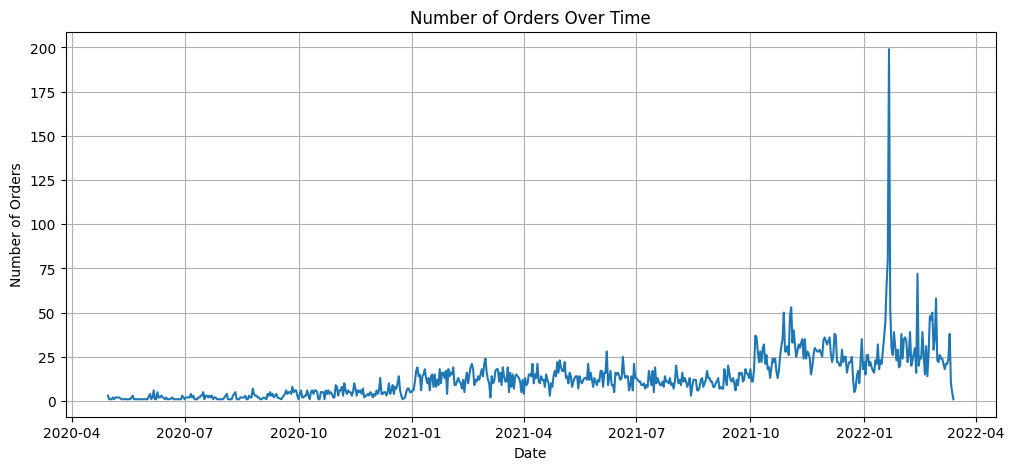

In [8]:
orders_per_day = orders_df.groupby('order_date').size()

plt.figure(figsize=(12, 5))
plt.plot(orders_per_day.index, orders_per_day.values)
plt.title('Number of Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

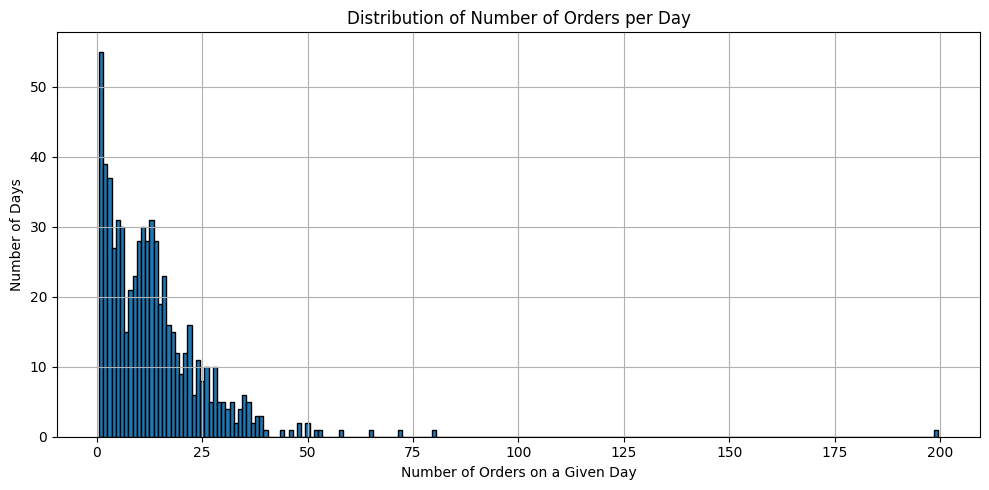

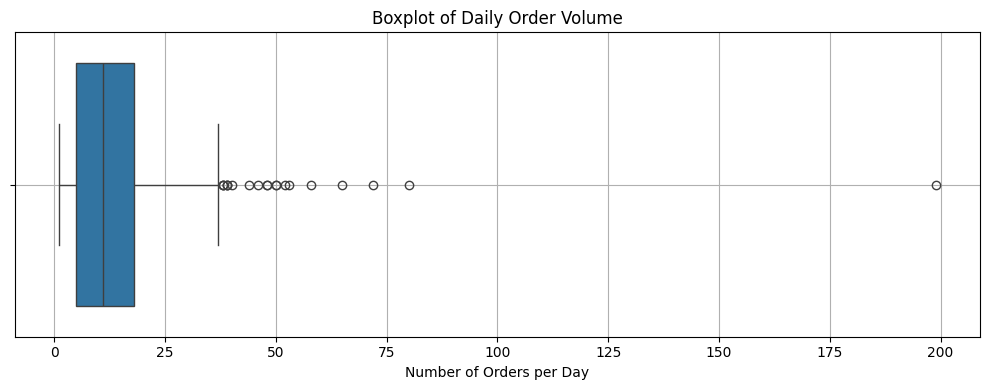

In [16]:
# Plot histogram of number of orders per day
plt.figure(figsize=(10, 5))
plt.hist(orders_per_day.values, bins=range(1, orders_per_day.max() + 2), edgecolor='black', align='left')
plt.title('Distribution of Number of Orders per Day')
plt.xlabel('Number of Orders on a Given Day')
plt.ylabel('Number of Days')
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot of number of orders per day
plt.figure(figsize=(10, 4))
sns.boxplot(x=orders_per_day.values)
plt.title('Boxplot of Daily Order Volume')
plt.xlabel('Number of Orders per Day')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
summary = orders_per_day.describe()
day_max_orders = orders_per_day.idxmax()

print("Summary Statistics of Daily Orders:")
print(summary)
print(f"Day with Maximum Orders: {day_max_orders} with {orders_per_day.max()} orders")

Summary Statistics of Daily Orders:
count    653.000000
mean      13.434916
std       13.161834
min        1.000000
25%        5.000000
50%       11.000000
75%       18.000000
max      199.000000
dtype: float64
Day with Maximum Orders: 2022-01-21 00:00:00 with 199 orders


Now we are going to look the number of items each orders has

In [23]:
orders_df['num_items'] = orders_df['ordered_items'].apply(len)

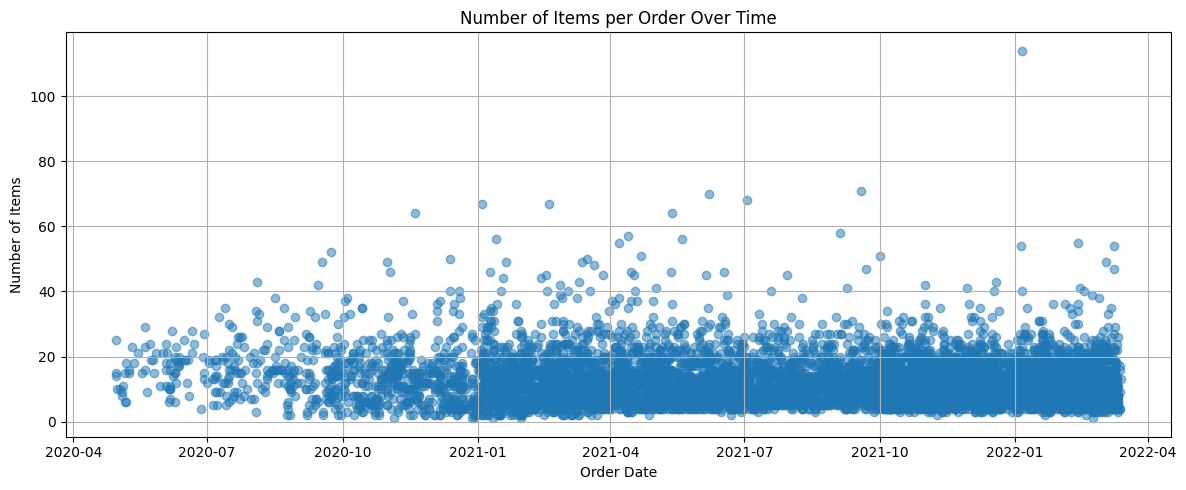

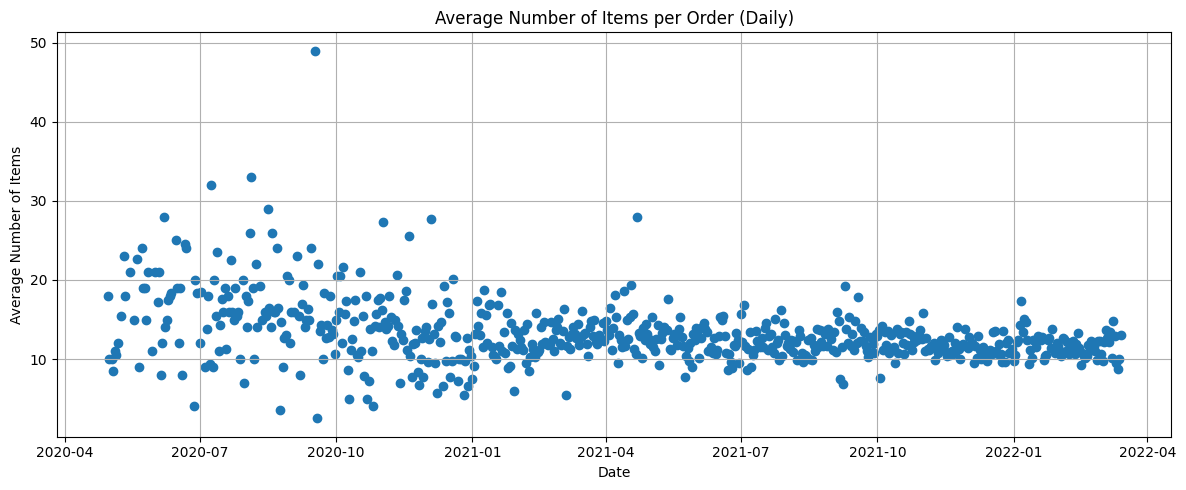

In [24]:
# Scatter plot: items per order over time
plt.figure(figsize=(12, 5))
plt.scatter(orders_df['order_date'], orders_df['num_items'], alpha=0.5)
plt.title('Number of Items per Order Over Time')
plt.xlabel('Order Date')
plt.ylabel('Number of Items')
plt.grid(True)
plt.tight_layout()
plt.show()

# Average number of items per day
avg_items_per_day = orders_df.groupby(orders_df['order_date'].dt.date)['num_items'].mean()

plt.figure(figsize=(12, 5))
plt.scatter(avg_items_per_day.index, avg_items_per_day.values, marker='o')
plt.title('Average Number of Items per Order (Daily)')
plt.xlabel('Date')
plt.ylabel('Average Number of Items')
plt.grid(True)
plt.tight_layout()
plt.show()


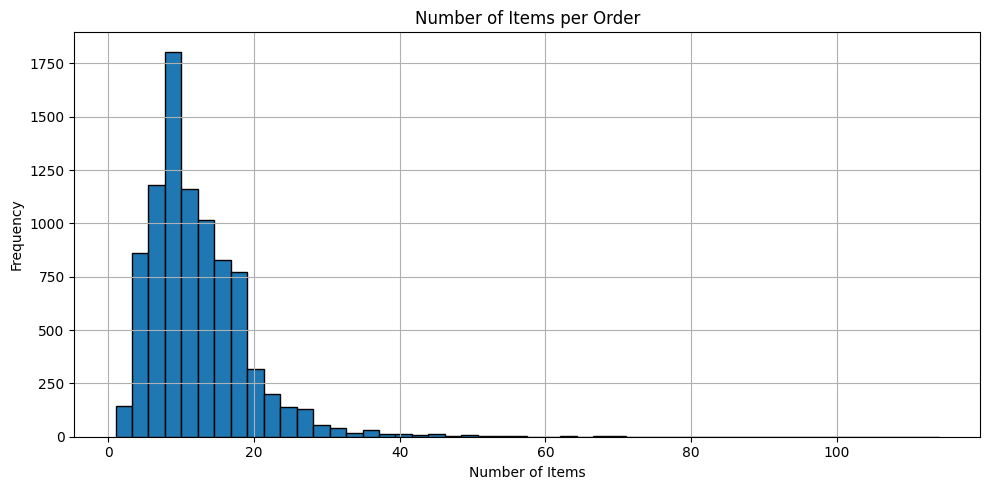

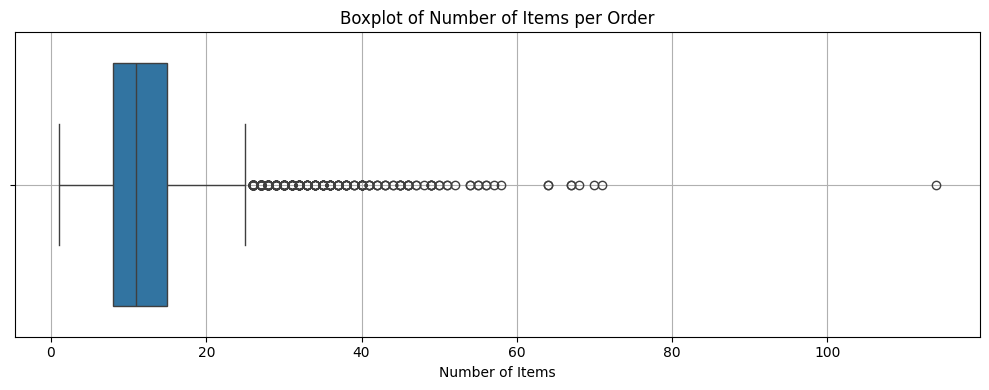

In [25]:
plot_dist_and_boxplot(orders_df, 'num_items', 'Number of Items per Order', 'Number of Items')

In [45]:
print(orders_df['num_items'].describe())
print(
    "Day with most items in an order: "
    f"{orders_df.loc[orders_df['num_items'].idxmax(), 'order_date']} "
    f"with {orders_df['num_items'].max()} items"
)

count    8773.000000
mean       12.305711
std         6.839507
min         1.000000
25%         8.000000
50%        11.000000
75%        15.000000
max       114.000000
Name: num_items, dtype: float64
Day with most items in an order: 2022-01-06 00:00:00 with 114 items


I'm going to save all items seen in ordered_items for future analysis

In [48]:
all_ordered_items = list(chain.from_iterable(orders_df['ordered_items']))
ordered_item_ids = set(all_ordered_items)
print(f"Total items ordered: {len(all_ordered_items)}")
print(f"Total unique items ordered: {len(ordered_item_ids)}")

Total items ordered: 107958
Total unique items ordered: 2117


### Regulars DataFrame

In [166]:
regulars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18105 entries, 3 to 37720
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18105 non-null  object        
 1   variant_id  18105 non-null  int64         
 2   created_at  18105 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 565.8+ KB


### Abandoned Carts DataFrame

In [167]:
abandoned_carts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5457 entries, 0 to 70050
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          5457 non-null   int64         
 1   user_id     5457 non-null   object        
 2   created_at  5457 non-null   datetime64[ns]
 3   variant_id  5457 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 213.2+ KB


### Inventory DataFrame

In [49]:
inventory_df.head()

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


Inventory should be the database for all items, so all the ordered items should appear here. Let's see

In [62]:
print(f"Unique items in orders: {len(ordered_item_ids)}")

inventory_item_ids = set(inventory_df['variant_id'])
print(f"Unique items in inventory: {len(inventory_item_ids)}")
missing_item_ids = ordered_item_ids - inventory_item_ids
print(
    f"Items in orders not in inventory: {len(missing_item_ids)} "
    f"({len(missing_item_ids) / len(ordered_item_ids) * 100:.2f}% missing)"
)

Unique items in orders: 2117
Unique items in inventory: 1733
Items in orders not in inventory: 640 (30.23% missing)


Oh, there are 640 items ordered without information in inventory

Now let's see other columns

In [63]:
vendor_description = inventory_df['vendor'].describe()
product_type_description = inventory_df['product_type'].describe()

print("Vendor Description:")
print(vendor_description)
print("\nProduct Type Description:")
print(product_type_description)
plt.show()

Vendor Description:
count      1733
unique      412
top       biona
freq         69
Name: vendor, dtype: object

Product Type Description:
count                  1733
unique                   59
top       cleaning-products
freq                    160
Name: product_type, dtype: object


Number of unique tags: 214


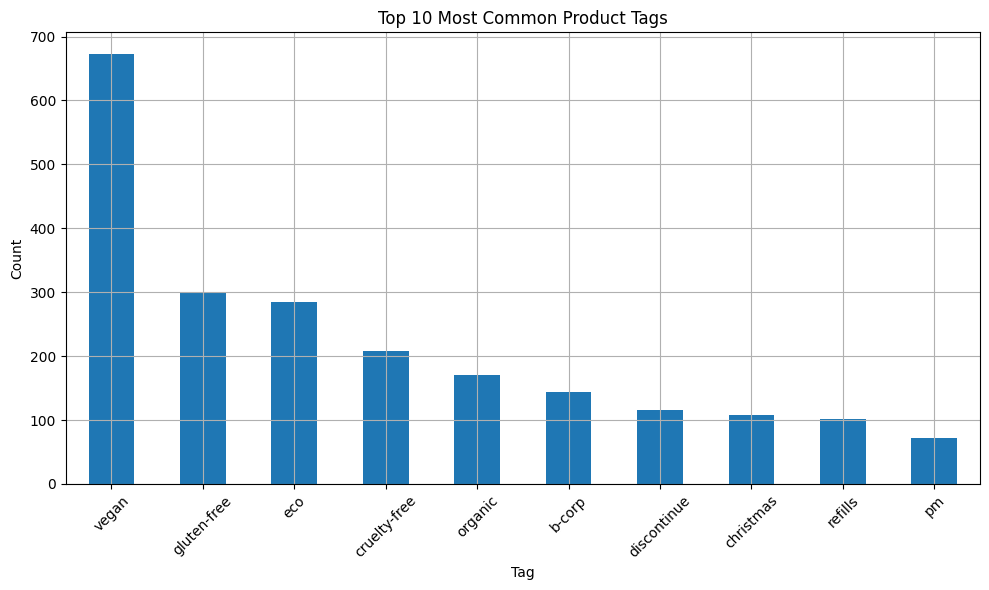

In [64]:
all_tags = inventory_df['tags'].explode()
unique_tags = all_tags.nunique()
print(f"Number of unique tags: {unique_tags}")

tag_counts = all_tags.value_counts()
top_tags = tag_counts.head(10)

plt.figure(figsize=(10, 6))
top_tags.plot(kind='bar')
plt.title('Top 10 Most Common Product Tags')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

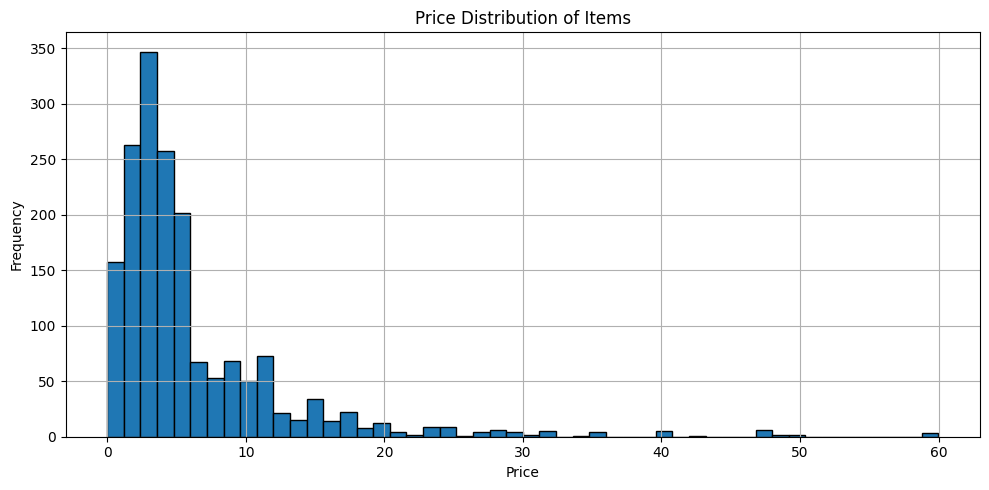

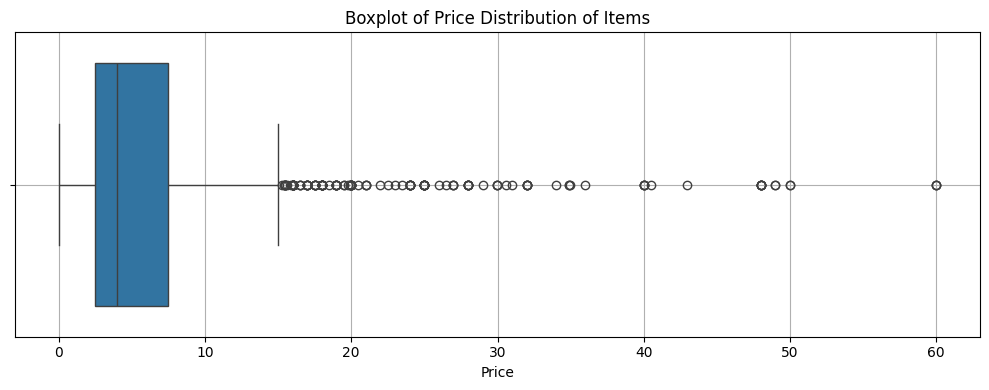

In [65]:
plot_dist_and_boxplot(inventory_df, 'price', 'Price Distribution of Items', 'Price')


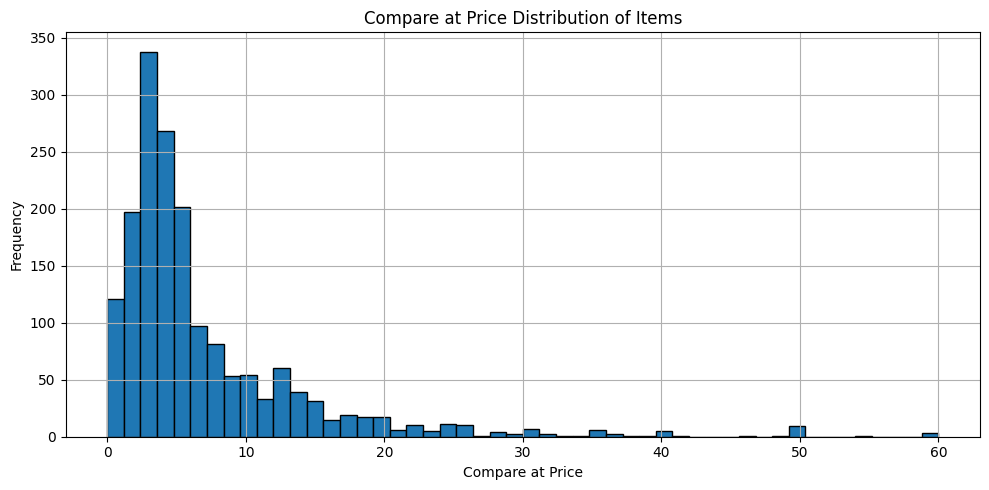

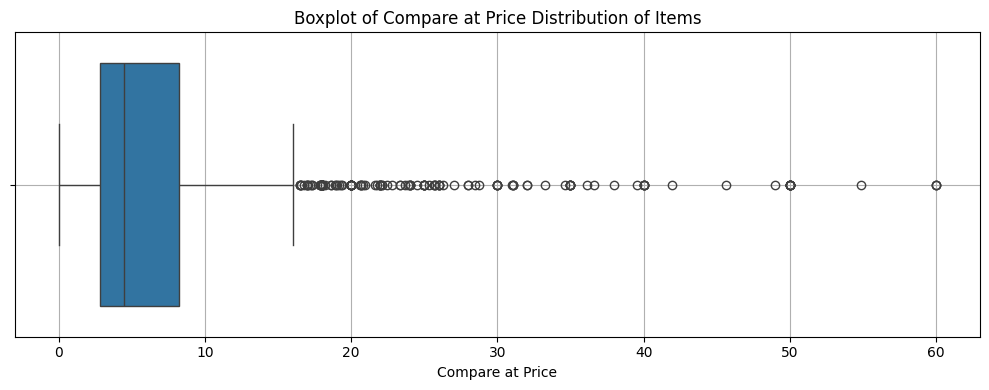

In [66]:
plot_dist_and_boxplot(inventory_df, 'compare_at_price', 'Compare at Price Distribution of Items', 'Compare at Price')

Let's see those items where price is 0.0 and those items compare price is 0.0

In [78]:
zero_price_items_df = inventory_df[inventory_df['price'] == 0]
zero_compare_at_price_items_df = inventory_df[inventory_df['compare_at_price'] == 0]

In [83]:
zero_price_items_df[zero_price_items_df['compare_at_price'] != 0]

,variant_id,price,compare_at_price,vendor,product_type,tags,discount_percent


In [84]:
zero_compare_at_price_items_df[zero_compare_at_price_items_df['price'] != 0]

,variant_id,price,compare_at_price,vendor,product_type,tags,discount_percent
586,40099114188932,0.01,0.0,bother,,"[discontinue, trade-swap]",-inf


We can see:
  - All items with 0.0 price have 0.0 compare_at_price
  - There is a single 0.0 compare_at_price item with price (0.01)


No much idea about what is compare_at_price, but seems that always is a bit higher than "price". Could be the original price to show when there is a promotion.  

price_at_compare -> discount -> price

Let's add a discount column

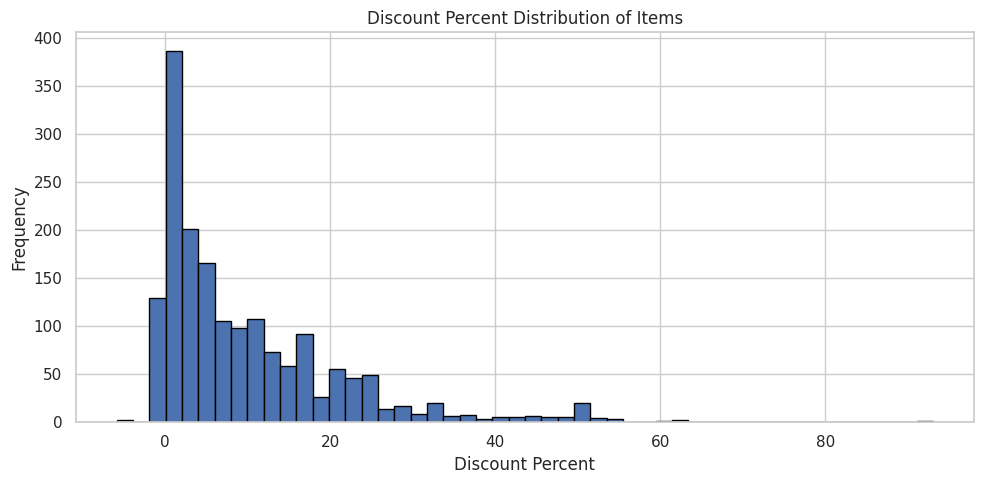

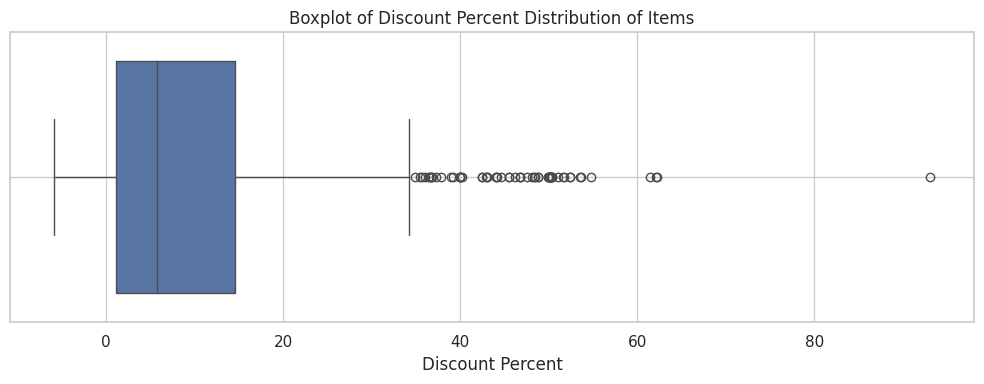

In [103]:
inventory_df['discount_percent'] = np.where(
    (inventory_df['compare_at_price'] > 0) & (inventory_df['price'] > 0),
    ((inventory_df['compare_at_price'] - inventory_df['price']) / inventory_df['compare_at_price']) * 100,
    0
)

plot_dist_and_boxplot(inventory_df, 'discount_percent', 'Discount Percent Distribution of Items', 'Discount Percent')

### Users DataFrame

In [96]:
print(f"Shape of users_df: {users_df.shape}")
users_df.head()

Shape of users_df: (4983, 10)


,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN
675,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'User Segments')

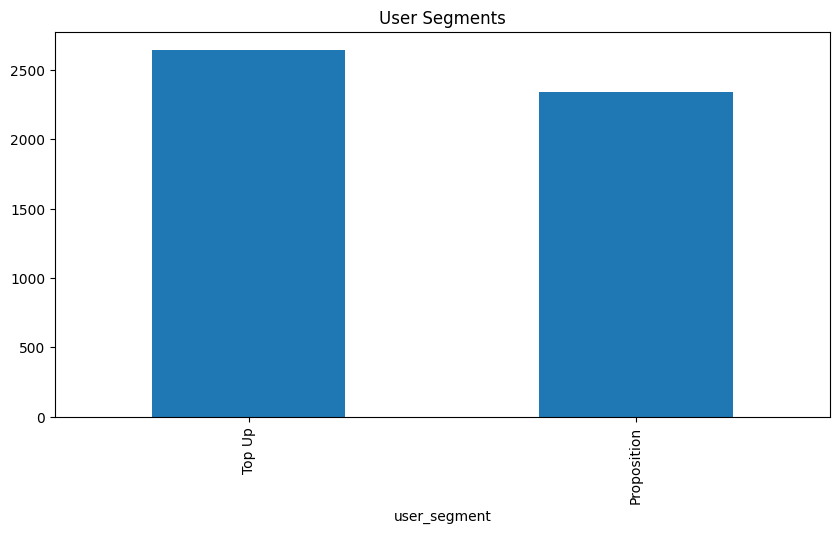

In [97]:
users_df['user_segment'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('User Segments')

Text(0.5, 1.0, 'User NUTS1 Regions')

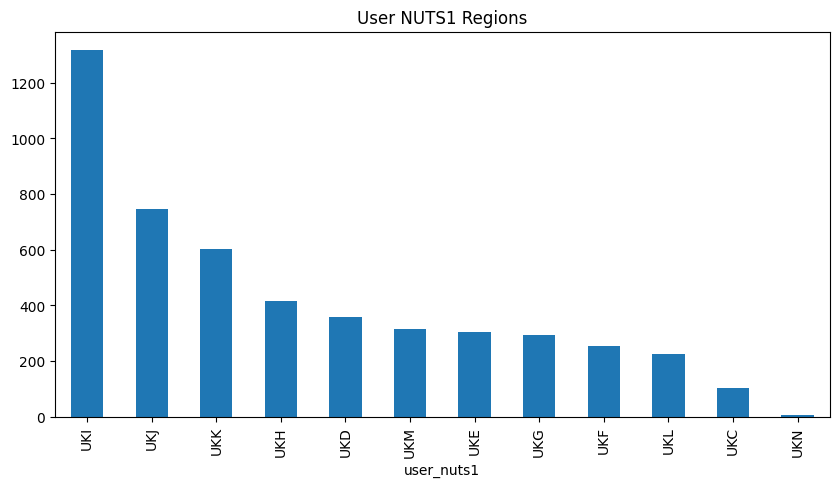

In [98]:
users_df['user_nuts1'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('User NUTS1 Regions')

In [99]:
columns = ['count_people', 'count_adults', 'count_children', 'count_babies', 'count_pets']

nan_stats = pd.DataFrame({
    'missing_count': users_df[columns].isna().sum(),
    'total_rows': len(users_df),
})

nan_stats['missing_percent'] = (nan_stats['missing_count'] / nan_stats['total_rows']) * 100
nan_stats = nan_stats.drop(columns='total_rows')  # optional

print(nan_stats)


                missing_count  missing_percent
count_people             4658        93.477825
count_adults             4658        93.477825
count_children           4658        93.477825
count_babies             4658        93.477825
count_pets               4658        93.477825


We can see the percent of nan values in each column is the same. So, if any user has a NaN value in one column, this means that this user hasn´t any value? And, if some user has a value in some of these columns, this means that it has taken all values? Let's see it

Text(0.5, 1.0, 'Count of Users by Number of NaNs in Group Columns')

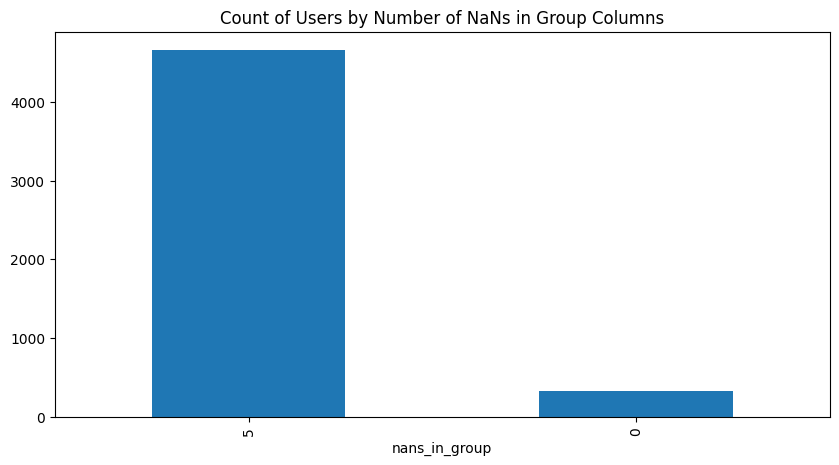

In [100]:
# For each user, count the number of NaN values in the specified columns
users_df['nans_in_group'] = users_df[columns].isna().sum(axis=1)

users_df['nans_in_group'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Count of Users by Number of NaNs in Group Columns')


Yes!! We can conclude that are users with all the columns with NaN, and are users with all the columns with correct values. But there aren´t users with parcialy filled data

So, what we should do with NaN values? Impute this group columns is dangerous, because the 93% of users have NaN values. Remove this columns from data should be an option.